<a href="https://colab.research.google.com/github/nbpyth97/Exercise/blob/master/Pstr_TP1_UNTRU_TEC_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Streams 2022
**= Gonçalo Castelo e Miguel Simões =**



## TP1 - Air Quality Monitoring (airborne particulate matter)
-- The goal of this project is to analyze data provided by a set of air quality sensors [sds011](https://aqicn.org/sensor/sds011/pt/). The sensors present in the dataset are located in Portugal, namely in the Lisbon metro area. Each sensor provides two values: measuring particles less than 10 µm (P1) and less than 2.5 µm (P2) in μg/m³.

The sensor data, spans the first half of 2020, and is streamed of Kafka. 

Each data sample has the following schema:

sensor_id | sensor_type | location | latitude | longitude | timestamp | P1 | P2
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| timestamp | float | float


## Questions

1. Find the time of day with the poorest air quality, for each location. Updated daily;
2. Find the average air quality, for each location. Updated hourly;
3. Can you show any daily and/or weekly patterns to air quality?;
4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

## R's **Data UnStructure**

In [1]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     |████████████████████████████████| 281.4 MB 30 kB/s 
     |████████████████████████████████| 198 kB 44.0 MB/s 


'/usr/local/lib/python3.7/dist-packages/pyspark'

In [2]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties

Formatting /tmp/kraft-combined-logs


In [3]:
#@title Start Socket-based Publisher
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/
# port 7777
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

## Q1

In [56]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext,1)
  lines = ssc.socketTextStream('localhost', 7777)
  line = lines.window(24,24)

  results=line.filter(lambda x : len(x)>0)\
  .map(lambda x:((x.split(' ')[2],x.split(' ')[-1][8:10]),(x.split(' ')[-3],x.split(' ')[-1])))\
  .reduceByKey(max)
  #.reduceByKey(lambda a,b: max(a+b))

  results.pprint()
    
  ssc.start()
  ssc.awaitTermination(72)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-03 12:33:52
-------------------------------------------
(('13691', '01'), ('97.07', '2020-01-01T18:45:09'))
(('14858', '01'), ('99.3', '2020-01-01T22:44:53'))
(('2332', '01'), ('99.8', '2020-01-01T17:04:04'))
(('10161', '01'), ('99.67', '2020-01-01T17:00:58'))
(('14857', '01'), ('99.57', '2020-01-01T12:26:59'))
(('19563', '01'), ('9.55', '2020-01-01T13:17:57'))

-------------------------------------------
Time: 2022-05-03 12:34:16
-------------------------------------------
(('13691', '01'), ('40.77', '2020-01-01T22:55:55'))
(('14858', '01'), ('95.27', '2020-01-01T23:19:34'))
(('2332', '01'), ('233.9', '2020-01-01T23:43:42'))
(('2332', '02'), ('87.1', '2020-01-02T04:12:52'))
(('13691', '02'), ('9.93', '2020-01-02T06:20:19'))
(('14858', '02'), ('99.95', '2020-01-02T15:54:02'))
(('10161', '01'), ('45.23', '2020-01-01T22:52:26'))
(('14857', '01'), ('71.03', '2020-01-01T23:18:12'))
(('19563', '01'), ('50.67', '2020-01-01T22:56:34'))

## Q2

In [ ]:
# Q2 UnStructured from socket

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1) # 1 segundo = 1 hora (batch de uma hora)
  lines = ssc.socketTextStream('localhost', 7777) 

# key local+hora e calcula média P1 - ordena pelo valor
  results=lines.filter(lambda x : len(x)>0)\
  .map(lambda x:((x.split(' ')[2]+' '+x.split(' ')[-1][11:13]),(float(x.split(' ')[-3]),1)))\
  .reduceByKey(lambda x, y: (x[1]+y[0], x[1]+y[1]))\
  .map(lambda x : (x[0],x[1][0]/x[1][1]))\
  .transform(lambda rdd: rdd.sortBy(lambda x: x[1], ascending=False))

  results.pprint(40)
  ssc.start()
  ssc.awaitTermination(10)

except Exception as err:
  print(err)

ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-03 01:51:05
-------------------------------------------
('14858 00', 14.613529411764706)
('14857 00', 10.470588235294118)
('10161 00', 9.381666666666668)
('13691 00', 1.8127777777777778)

-------------------------------------------
Time: 2022-05-03 01:51:06
-------------------------------------------
('2332 00', 88.64999999999999)
('14858 00', 39.416666666666664)
('14857 00', 21.995)
('2332 01', 21.34277777777778)
('10161 00', 17.721666666666668)
('14858 01', 12.429444444444444)
('14857 01', 7.120555555555557)
('10161 01', 6.026111111111111)
('13691 00', 5.957142857142857)
('13691 01', 1.6205555555555557)

-------------------------------------------
Time: 2022-05-03 01:51:07
-------------------------------------------
('2332 01', 75.486)
('19563 02', 46.72)
('14858 01', 29.406)
('14857 01', 17.466)
('10161 01', 14.0)
('2332 02', 11.920555555555556)
('14858 02', 9.795333333333334)
('14857 02', 5.339375)
('10161 02', 4.88789473684

## Q3

-------------------------------------------
Time: 2022-05-03 14:25:34
-------------------------------------------
('13691', '00', 19.83)
('13691', '00', 19.07)
('13691', '00', 15.73)
('13691', '00', 18.4)
('13691', '00', 16.67)
('13691', '00', 23.73)
('13691', '00', 39.33)
('13691', '00', 128.13)
('13691', '00', 74.9)
('13691', '00', 33.93)
...

   location timestamp  pollution  Mean Values
0     13691        00      19.83          NaN
1     13691        00      19.07          NaN
2     13691        00      15.73          NaN
3     13691        00      18.40          NaN
4     13691        00      16.67          NaN
5     13691        00      23.73          NaN
6     13691        00      39.33          NaN
7     13691        00     128.13          NaN
8     13691        00      74.90          NaN
9     13691        00      33.93          NaN
10    13691        00      24.43          NaN
11    13691        00      21.33          NaN
12    13691        00      22.80          NaN
13    13

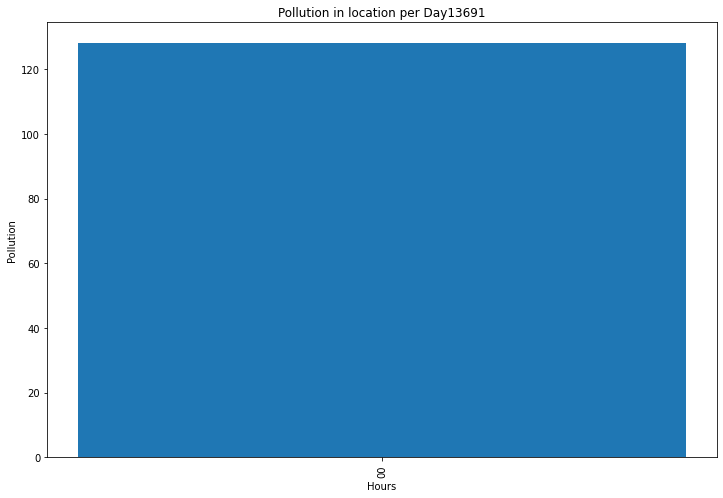

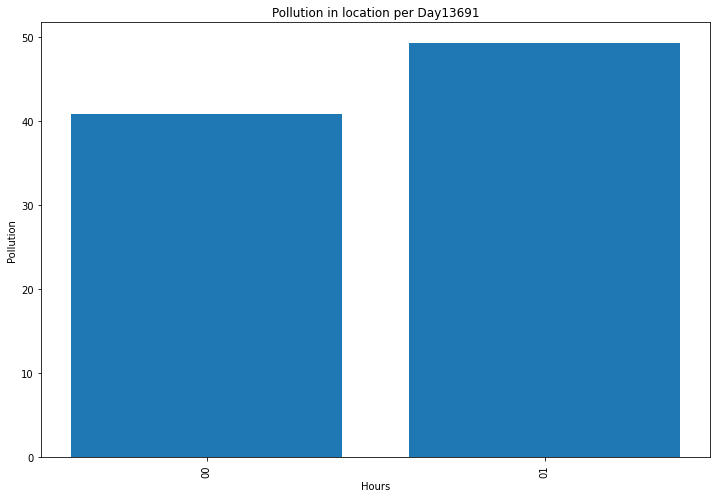

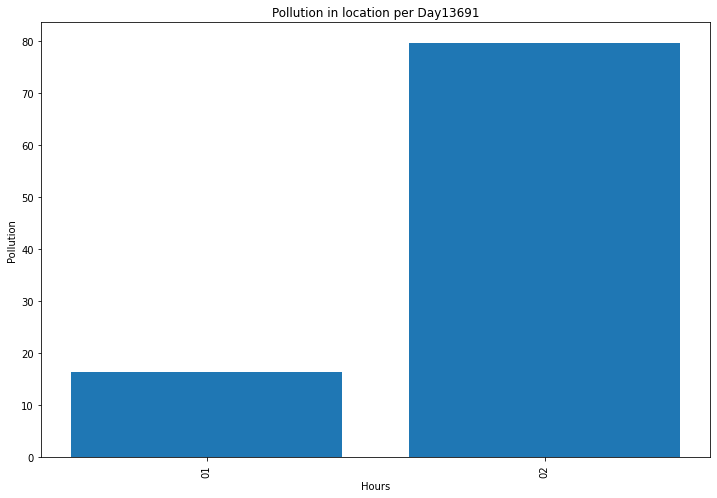

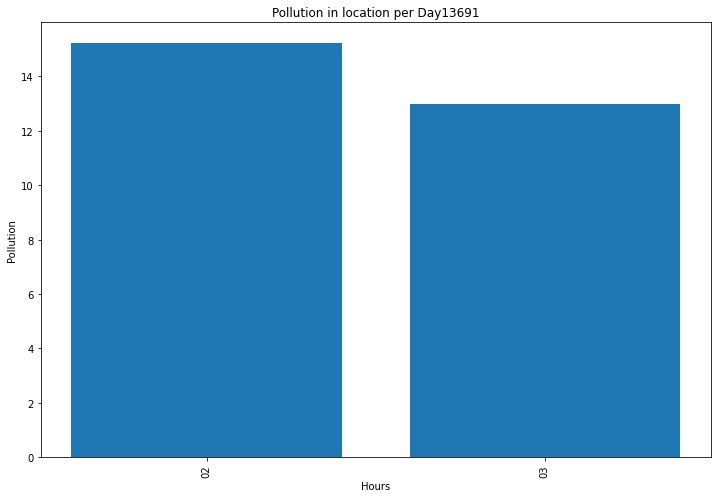

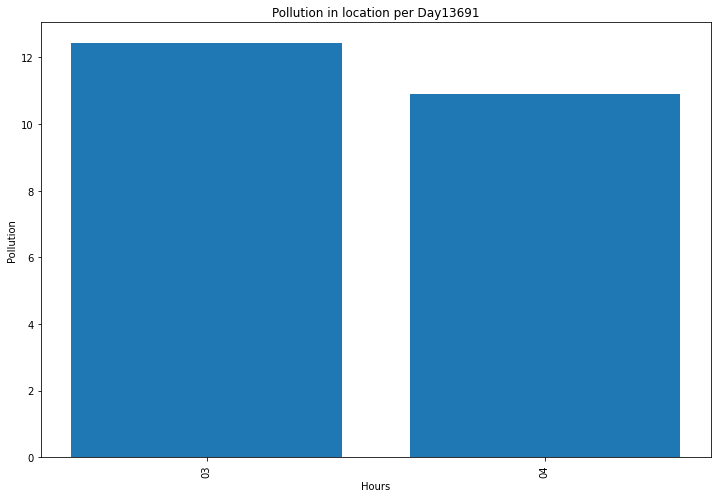

In [83]:
from IPython.core.pylabtools import figsize
# Q3 UnStrutured, from socket

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.types import StringType, StructField, StructType

import pandas as pd
import matplotlib.pyplot as plt

# location | timestamp | P1

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

loc_cod = '13691'

# plot data
def convert_to_df(rdd):

  if rdd.isEmpty() is True:
    pass
  else:
    try:
      df = spark.createDataFrame(rdd)
      df_pandas = df.toPandas()
      df_pandas.columns = ['location', 'timestamp', 'pollution']
      df_pandas['Mean Values']= df_pandas.groupby(['timestamp']).max('pollution')

      #df_pandas['pollution MA'] = df_pandas.pollution.rolling(window=5).mean()
      print(df_pandas)

      #labels
      plt.figure(figsize=(12, 8))
      plt.xlabel("Hours")
      plt.ylabel("Pollution")
      plt.title("Pollution in location per Day"+loc_cod)
      plt.xticks(rotation=90)
      plt.bar(df_pandas['timestamp'],df_pandas['pollution'])
      plt.plot(df_pandas['timestamp'],df_pandas['pollution MA'], color='red', linewidth=4)
      plt.show()
    
    except Exception as err:
      print(err) 

# main code
try:
  # dataset socket
  ssc = StreamingContext(spark.sparkContext, 1) # batch 1s
  lines = ssc.socketTextStream('localhost', 7777) 
  line = lines.window(1,1) # 24s (one day)
 
  # location hours P1, location in loc_cod
  results=line.filter(lambda x : len(x)>0)\
  .map(lambda x:(x.split(' ')[2],x.split(' ')[-1][11:13],float(x.split(' ')[-3])))\
  .filter(lambda x : x[0] == loc_cod)
  
  results.pprint(10)
  results.foreachRDD(convert_to_df)
  ssc.start()
  ssc.awaitTermination(5)

except Exception as err:
  print(err)

ssc.stop()
spark.stop()

## Q4

The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

In [73]:
# Q4 UnStrutured, from socket

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.types import StringType, StructField, StructType

import pandas as pd
import matplotlib.pyplot as plt

# location | timestamp | P1

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

loc_cod = '13691'

# plot data
def convert_to_df(rdd):
    if rdd.isEmpty() is True:
      pass
    else:
      try:
        df = spark.createDataFrame(rdd)
        df_pandas = df.toPandas()
        df_pandas.columns = ['location', 'timestamp', 'pollution']
        
        #labels
        plt.figure(figsize=(12, 8))
        plt.xlabel("Hours")
        plt.ylabel("Pollution")
        plt.title("Pollution in location per Day"+loc_cod)
        plt.xticks(rotation=90)
        plt.bar(df_pandas['timestamp'],df_pandas['pollution'])
        plt.show()

      except Exception as err:
        print(err) 

# main code
try:

  # dataset socket
  ssc = StreamingContext(spark.sparkContext, 1) # batch 1s
  lines = ssc.socketTextStream('localhost', 7777) 
  line = lines.window(24,24) # 30x24s (one Mouth)
 
  # location hours P1, location in loc_cod
  results=line.filter(lambda x : len(x)>0)\
  .map(lambda x:((x.split(' ')[2],x.split(' ')[-1][0:10]),(float(x.split(' ')[-3]),1)))\
  .filter(lambda x : x[0][0] == loc_cod)\
  .reduceByKey(lambda x, y: (x[1]+y[0], x[1]+y[1]))\
  .map(lambda x : (x[0],x[1][0]/x[1][1]))
  
  results.pprint(10)
  results.foreachRDD(convert_to_df)  
  ssc.start()
  ssc.awaitTermination(40)

except Exception as err:
  print(err)

ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-05-03 13:59:12
-------------------------------------------
('13691 2020-01-01', 1.0476215277777776)
('14858 2020-01-01', 1.1392377495462795)
('14857 2020-01-01', 1.089799635701275)
('19563 2020-01-01', 1.1211851851851853)
('10161 2020-01-01', 1.0623170731707317)
('2332 2020-01-01', 1.6857094594594595)

Length mismatch: Expected axis has 2 elements, new values have 3 elements
